In [6]:
import random
from functools import partial

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from casadi import dot, vertsplit, vertcat

from do_mpc.model import Model
from do_mpc.controller import MPC
from do_mpc.estimator import StateFeedback
from do_mpc.simulator import Simulator

from core.generator import (
    gen_step,
)
from core.greenhouse_model import _model, model
from core.plot import plot_response, plot_states
from core.simulate import simulate
from core.openmeteo_query import get_weather_data
from examples.GES_Example import z

# For reproducibility
random.seed(40)

# Enable automatic module reload
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Get Weather Data

In [7]:
climdat = get_weather_data(
    latitude=52.52,  # Latitude of the location in degrees
    longitude=13.41,  # Longitude of the location in degrees
    tilt=[
        90,
        40,
        90,
        40,
        90,
        40,
        90,
        40,
    ],  # Tilt angle of the surface in degrees
    azimuth=[
        "NE",
        "NE",
        "SE",
        "SE",
        "SW",
        "SW",
        "NW",
        "NW",
    ],  # Azimuth angle of the surface in degrees (South facing)
    frequency="hourly",
    forecast=3,
)

climate = climdat.asfreq("1T").interpolate(method="time").values

## Explore responses to steps in individual inputs

In [8]:
x0 = z
u_min = [0.0, 0.0]
u_max = [3600.0, 1e4]

In [9]:
y_label = [r"$x_{\mathrm{sdw}}$", r"$x_{\mathrm{nsdw}}$"]
u_label = [
    r"$u_{\mathrm{R_{a,max}}}$",
    r"$u_{\mathrm{Q_{heat}}}$",
]

In [10]:
greenhouse_model = partial(model, climate=climate)

/Users/marekwadinger/PyProjects/dynamic_opt_growth_model/core/greenhouse_model.py:796: RuntimeWarning: overflow encountered in exp
  * (1 - np.exp(-c_RGR * R_fruit))
/Users/marekwadinger/PyProjects/dynamic_opt_growth_model/core/greenhouse_model.py:802: RuntimeWarning: overflow encountered in exp
  * (1 - np.exp(-c_RGR * R_leaf))
/Users/marekwadinger/PyProjects/dynamic_opt_growth_model/core/greenhouse_model.py:808: RuntimeWarning: overflow encountered in exp
  * (1 - np.exp(-c_RGR * R_stem))


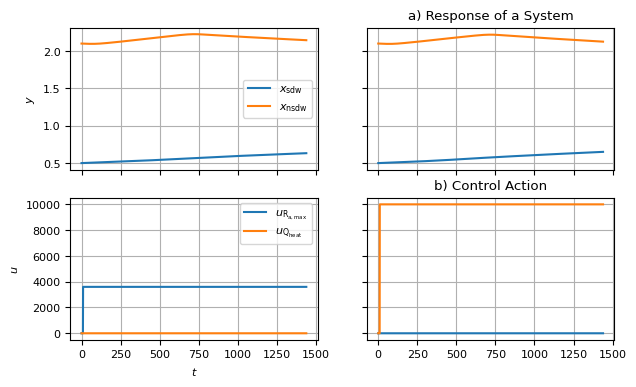

In [11]:
fig, axs = plt.subplots(nrows=2, ncols=len(u_max), sharex=True, sharey="row")

for u_idx in range(len(u_max)):
    u_max_ = u_min.copy()
    u_max_[u_idx] = u_max[u_idx]
    u = partial(gen_step, u_min=u_min, u_max=u_max_)
    t_out, y_out, u_out = simulate(
        greenhouse_model, u=u, sim_time=1440, t_s=60, x0=x0
    )
    plot_response(
        t_out,
        y_out[:, -2:],
        u_out,
        axs_=axs[:, u_idx],
        y_label=y_label,
        u_label=u_label,
    )

axs[0, 0].set_ylabel("$y$")
axs[0, 1].set_title("a) Response of a System")
axs[0, 0].legend()
axs[1, 0].set_xlabel("$t$")
axs[1, 0].set_ylabel("$u$")
axs[1, 1].set_title("b) Control Action")
axs[1, 0].legend()

plt.show()

### Plot all the hidden states

In [12]:
_greenhouse_model = partial(_model, climate=climate)

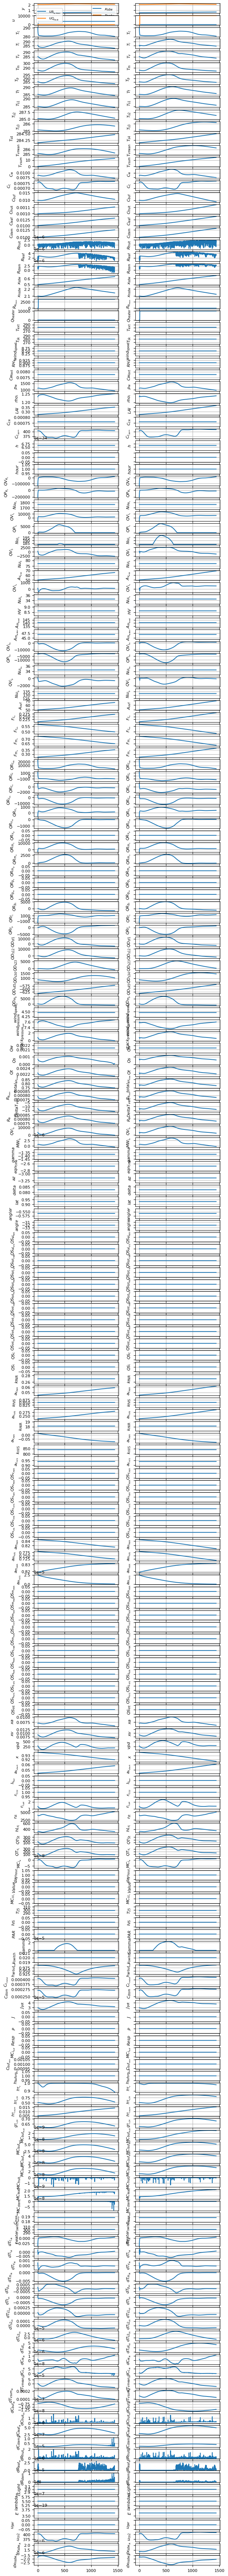

In [13]:
for u_idx in range(len(u_max)):
    u_max_ = u_min.copy()
    u_max_[u_idx] = u_max[u_idx]
    u = partial(gen_step, u_min=u_min, u_max=u_max_)
    t_out, y_out, u_out = simulate(
        greenhouse_model, u=u, sim_time=1440, t_s=60, x0=x0
    )

    xs = []
    for x, u in zip(y_out, u_out):
        _, x_ = _greenhouse_model(0, tuple(x), tuple(u))
        xs.append(x_)
    df = pd.DataFrame(xs).select_dtypes(include=["float"])

    if u_idx == 0:
        # Plot response
        fig, axs = plt.subplots(
            nrows=2 + len(df.columns),
            ncols=len(u_max),
            figsize=(6, round(len(df.columns) / 2)),
            sharex=True,
            sharey="row",
        )
    plot_response(
        t_out,
        y_out[:, -2:],
        u_out,
        axs_=axs[:, u_idx],
        y_label=y_label,
        u_label=u_label,
    )
    # Plot states
    plot_states(df, axs[2:, u_idx])

axs[0, 0].set_ylabel("$y$")
axs[0, 0].legend()
axs[1, 0].set_xlabel("$t$")
axs[1, 0].set_ylabel("$u$")
axs[1, 0].legend()

plt.show()

In [36]:
# Create a model instance
model = Model("discrete")

n_states = 23
n_controls = 2
# Define state and control variables
x = model.set_variable(var_type="_x", var_name="x", shape=(n_states, 1))
u = model.set_variable(var_type="_u", var_name="u", shape=(n_controls, 1))


def f(x, u):
    return vertcat(greenhouse_model(0, vertsplit(x), vertsplit(u)))


N = 50  # number of control intervals
sec_in_day = 86400

dt = sec_in_day * 15 / N

k1 = f(x[:, 0], u[:, 0])
k2 = f(x[:, 0] + dt / 2 * k1, u[:, 0])
k3 = f(x[:, 0] + dt / 2 * k2, u[:, 0])
k4 = f(x[:, 0] + dt * k3, u[:, 0])
x_next = x[:, 0] + dt / 6 * (k1 + 2 * k2 + 2 * k3 + k4)

model.set_rhs("x", x_next)

model.setup()

# Define parameters
x_ref = np.array([50.0, 5.0])  # reference state
u_min = [-10.0, 0.0]
u_max = [25.0, 200.0]

# Create an MPC instance
mpc = MPC(model)

# Set parameters
setup_mpc = {
    "n_horizon": N,
    "t_step": sec_in_day,
    "store_full_solution": True,
    "use_terminal_bounds": True,
}
mpc.set_param(**setup_mpc)

# Define objective
mpc.set_objective(
    mterm=dot(x[-1, 0] - x_ref[0], x[-1, 0] - x_ref[0]),
    lterm=dot(x[:, 0] - x_ref[0], x[:, 0] - x_ref[0]),
)

mpc.set_rterm(
    u=np.array([0.1] * n_controls)
)  # Parametrize with size of greenhouse and Ts


# mpc.terminal_bounds
# Define path constraints
mpc.bounds["lower", "_u", "u"] = u_min
mpc.bounds["upper", "_u", "u"] = u_max

mpc.bounds["lower", "_x", "x"] = [0.01] * 23

# Define miscellaneous constraints
# mpc.bounds["upper", "_u", "t"] = sec_in_day * 15

mpc.terminal_bounds["lower", "x"] = 50

mpc.setup()

estimator = StateFeedback(model)

# Create a simulator
simulator = Simulator(model)

params_simulator = {"t_step": sec_in_day}

simulator.set_param(**params_simulator)

simulator.setup()

x0_ = np.array(x0)
mpc.x0 = x0_
simulator.x0 = x0_
estimator.x0 = x0_
mpc.set_initial_guess()

# Run the MPC simulation
u0s = []
y_nexts = []
x0s = []
u0 = [float("nan")] * n_controls
ums = []
uos = []
for k in range(50):
    u_out = [
        100.0,
        1100.0,
    ]
    uos.append(u_out)
    u_min_ = u_min.copy()
    u_max_ = u_max.copy()
    for i, u_real_value in enumerate(u_out):
        # Compare u_real with u
        if u_real_value > u0[i]:
            # If u_real is higher than u, update u_max
            u_max_[i] = u_real_value
            u_min_[i] = u0[i][0]
        elif u_real_value <= u0[i]:
            # Otherwise, update u_min
            u_min_[i] = u_real_value
            u_max_[i] = u0[i][0]
    ums.append([u_min_, u_max_])
    mpc.bounds["upper", "_u", "u"] = u_max_
    mpc.bounds["lower", "_u", "u"] = u_min_
    u0 = mpc.make_step(x0_)
    u0s.append(u0)
    y_next = simulator.make_step(u0)
    y_nexts.append(y_next)
    x0_ = estimator.make_step(y_next)
    x0s.append(x0_)

This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:    22273
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:    14449

Error evaluating Jacobian of equality constraints at user provided starting point.
  No scaling factors for equality constraints computed!

Number of Iterations....: 0

Number of objective function evaluations             = 0
Number of objective gradient evaluations             = 0
Number of equality constraint evaluations            = 0
Number of inequality constraint evaluations          = 0
Number of equality constraint Jacobian evaluations   = 1
Number of inequality constraint Jacobian evaluations = 0
Number of Lagrangian Hessian evaluations             = 0
Total seconds in IPOPT                               = 0.018

EXIT: Invalid number in NLP function or derivative detected.
           S  :   t_proc      (avg)   t_wall

CasADi - 2024-03-04 14:11:06 WARNING("S:nlp_jac_g failed: NaN detected for output jac_g_x, at nonzero index 1 (row 23, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-03-04 14:11:06 WARNING("S:nlp_jac_g failed: NaN detected for output jac_g_x, at nonzero index 1 (row 23, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-03-04 14:11:06 WARNING("S:nlp_jac_g failed: NaN detected for output jac_g_x, at nonzero index 1 (row 23, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-03-04 14:11:06 WARNING("S:nlp_jac_g failed: NaN detected for output jac_g_x, at nonzero index 1 (row 23, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-03-04 14:11:06 WARNING("S:nlp_jac_g failed: NaN detected for output jac_g_x, at nonzero index 1 (row 23, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-03-04 14:11:06 WARNING("S:nlp_jac_g failed: NaN detected for output jac_g_x, at nonzero index 1 (row 23, col 0).") [.../casadi/core

This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:    22273
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:    14449

Error evaluating Jacobian of equality constraints at user provided starting point.
  No scaling factors for equality constraints computed!

Number of Iterations....: 0

Number of objective function evaluations             = 0
Number of objective gradient evaluations             = 0
Number of equality constraint evaluations            = 0
Number of inequality constraint evaluations          = 0
Number of equality constraint Jacobian evaluations   = 1
Number of inequality constraint Jacobian evaluations = 0
Number of Lagrangian Hessian evaluations             = 0
Total seconds in IPOPT                               = 0.012

EXIT: Invalid number in NLP function or derivative detected.
           S  :   t_proc      (avg)   t_wall

CasADi - 2024-03-04 14:11:06 WARNING("S:nlp_jac_g failed: NaN detected for output jac_g_x, at nonzero index 1 (row 23, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-03-04 14:11:06 WARNING("S:nlp_jac_g failed: NaN detected for output jac_g_x, at nonzero index 1 (row 23, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-03-04 14:11:06 WARNING("S:nlp_jac_g failed: NaN detected for output jac_g_x, at nonzero index 1 (row 23, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-03-04 14:11:06 WARNING("S:nlp_jac_g failed: NaN detected for output jac_g_x, at nonzero index 1 (row 23, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-03-04 14:11:06 WARNING("S:nlp_jac_g failed: NaN detected for output jac_g_x, at nonzero index 1 (row 23, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-03-04 14:11:06 WARNING("S:nlp_jac_g failed: NaN detected for output jac_g_x, at nonzero index 1 (row 23, col 0).") [.../casadi/core

This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:    22273
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:    14449

Error evaluating Jacobian of equality constraints at user provided starting point.
  No scaling factors for equality constraints computed!

Number of Iterations....: 0

Number of objective function evaluations             = 0
Number of objective gradient evaluations             = 0
Number of equality constraint evaluations            = 0
Number of inequality constraint evaluations          = 0
Number of equality constraint Jacobian evaluations   = 1
Number of inequality constraint Jacobian evaluations = 0
Number of Lagrangian Hessian evaluations             = 0
Total seconds in IPOPT                               = 0.012

EXIT: Invalid number in NLP function or derivative detected.
           S  :   t_proc      (avg)   t_wall

CasADi - 2024-03-04 14:11:06 WARNING("S:nlp_jac_g failed: NaN detected for output jac_g_x, at nonzero index 1 (row 23, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-03-04 14:11:06 WARNING("S:nlp_jac_g failed: NaN detected for output jac_g_x, at nonzero index 1 (row 23, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-03-04 14:11:06 WARNING("S:nlp_jac_g failed: NaN detected for output jac_g_x, at nonzero index 1 (row 23, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-03-04 14:11:06 WARNING("S:nlp_jac_g failed: NaN detected for output jac_g_x, at nonzero index 1 (row 23, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-03-04 14:11:06 WARNING("S:nlp_jac_g failed: NaN detected for output jac_g_x, at nonzero index 1 (row 23, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-03-04 14:11:06 WARNING("S:nlp_jac_g failed: NaN detected for output jac_g_x, at nonzero index 1 (row 23, col 0).") [.../casadi/core

Error evaluating Jacobian of equality constraints at user provided starting point.
  No scaling factors for equality constraints computed!

Number of Iterations....: 0

Number of objective function evaluations             = 0
Number of objective gradient evaluations             = 0
Number of equality constraint evaluations            = 0
Number of inequality constraint evaluations          = 0
Number of equality constraint Jacobian evaluations   = 1
Number of inequality constraint Jacobian evaluations = 0
Number of Lagrangian Hessian evaluations             = 0
Total seconds in IPOPT                               = 0.012

EXIT: Invalid number in NLP function or derivative detected.
           S  :   t_proc      (avg)   t_wall      (avg)    n_eval
    nlp_grad  |  19.97ms (998.30us)  20.48ms (  1.02ms)        20
  nlp_grad_f  | 400.00us ( 19.05us) 383.08us ( 18.24us)        21
   nlp_jac_g  | 250.05ms (  5.95ms) 259.74ms (  6.18ms)        42
       total  |  12.88ms ( 12.88ms)  12.89ms 

CasADi - 2024-03-04 14:11:06 WARNING("S:nlp_jac_g failed: NaN detected for output jac_g_x, at nonzero index 1 (row 23, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-03-04 14:11:06 WARNING("S:nlp_jac_g failed: NaN detected for output jac_g_x, at nonzero index 1 (row 23, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-03-04 14:11:06 WARNING("S:nlp_jac_g failed: NaN detected for output jac_g_x, at nonzero index 1 (row 23, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-03-04 14:11:06 WARNING("S:nlp_jac_g failed: NaN detected for output jac_g_x, at nonzero index 1 (row 23, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-03-04 14:11:06 WARNING("S:nlp_jac_g failed: NaN detected for output jac_g_x, at nonzero index 1 (row 23, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-03-04 14:11:06 WARNING("S:nlp_jac_g failed: NaN detected for output jac_g_x, at nonzero index 1 (row 23, col 0).") [.../casadi/core


Number of Iterations....: 0

Number of objective function evaluations             = 0
Number of objective gradient evaluations             = 0
Number of equality constraint evaluations            = 0
Number of inequality constraint evaluations          = 0
Number of equality constraint Jacobian evaluations   = 1
Number of inequality constraint Jacobian evaluations = 0
Number of Lagrangian Hessian evaluations             = 0
Total seconds in IPOPT                               = 0.012

EXIT: Invalid number in NLP function or derivative detected.
           S  :   t_proc      (avg)   t_wall      (avg)    n_eval
    nlp_grad  |  26.39ms (977.26us)  26.93ms (997.53us)        27
  nlp_grad_f  | 524.00us ( 18.71us) 500.58us ( 17.88us)        28
   nlp_jac_g  | 330.66ms (  5.90ms) 341.51ms (  6.10ms)        56
       total  |  13.02ms ( 13.02ms)  13.07ms ( 13.07ms)         1
This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jaco

CasADi - 2024-03-04 14:11:06 WARNING("S:nlp_jac_g failed: NaN detected for output jac_g_x, at nonzero index 1 (row 23, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-03-04 14:11:06 WARNING("S:nlp_jac_g failed: NaN detected for output jac_g_x, at nonzero index 1 (row 23, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-03-04 14:11:06 WARNING("S:nlp_jac_g failed: NaN detected for output jac_g_x, at nonzero index 1 (row 23, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-03-04 14:11:06 WARNING("S:nlp_jac_g failed: NaN detected for output jac_g_x, at nonzero index 1 (row 23, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-03-04 14:11:07 WARNING("S:nlp_jac_g failed: NaN detected for output jac_g_x, at nonzero index 1 (row 23, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-03-04 14:11:07 WARNING("S:nlp_jac_g failed: NaN detected for output jac_g_x, at nonzero index 1 (row 23, col 0).") [.../casadi/core

This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:    22273
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:    14449

Error evaluating Jacobian of equality constraints at user provided starting point.
  No scaling factors for equality constraints computed!

Number of Iterations....: 0

Number of objective function evaluations             = 0
Number of objective gradient evaluations             = 0
Number of equality constraint evaluations            = 0
Number of inequality constraint evaluations          = 0
Number of equality constraint Jacobian evaluations   = 1
Number of inequality constraint Jacobian evaluations = 0
Number of Lagrangian Hessian evaluations             = 0
Total seconds in IPOPT                               = 0.013

EXIT: Invalid number in NLP function or derivative detected.
           S  :   t_proc      (avg)   t_wall

CasADi - 2024-03-04 14:11:07 WARNING("S:nlp_jac_g failed: NaN detected for output jac_g_x, at nonzero index 1 (row 23, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-03-04 14:11:07 WARNING("S:nlp_jac_g failed: NaN detected for output jac_g_x, at nonzero index 1 (row 23, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-03-04 14:11:07 WARNING("S:nlp_jac_g failed: NaN detected for output jac_g_x, at nonzero index 1 (row 23, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-03-04 14:11:07 WARNING("S:nlp_jac_g failed: NaN detected for output jac_g_x, at nonzero index 1 (row 23, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-03-04 14:11:07 WARNING("S:nlp_jac_g failed: NaN detected for output jac_g_x, at nonzero index 1 (row 23, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-03-04 14:11:07 WARNING("S:nlp_jac_g failed: NaN detected for output jac_g_x, at nonzero index 1 (row 23, col 0).") [.../casadi/core


Number of Iterations....: 0

Number of objective function evaluations             = 0
Number of objective gradient evaluations             = 0
Number of equality constraint evaluations            = 0
Number of inequality constraint evaluations          = 0
Number of equality constraint Jacobian evaluations   = 1
Number of inequality constraint Jacobian evaluations = 0
Number of Lagrangian Hessian evaluations             = 0
Total seconds in IPOPT                               = 0.011

EXIT: Invalid number in NLP function or derivative detected.
           S  :   t_proc      (avg)   t_wall      (avg)    n_eval
    nlp_grad  |  40.33ms (960.24us)  41.17ms (980.20us)        42
  nlp_grad_f  | 768.00us ( 17.86us) 738.46us ( 17.17us)        43
   nlp_jac_g  | 500.85ms (  5.82ms) 513.50ms (  5.97ms)        86
       total  |  12.74ms ( 12.74ms)  12.73ms ( 12.73ms)         1
This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jaco

CasADi - 2024-03-04 14:11:07 WARNING("S:nlp_jac_g failed: NaN detected for output jac_g_x, at nonzero index 1 (row 23, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-03-04 14:11:07 WARNING("S:nlp_jac_g failed: NaN detected for output jac_g_x, at nonzero index 1 (row 23, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-03-04 14:11:07 WARNING("S:nlp_jac_g failed: NaN detected for output jac_g_x, at nonzero index 1 (row 23, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-03-04 14:11:07 WARNING("S:nlp_jac_g failed: NaN detected for output jac_g_x, at nonzero index 1 (row 23, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-03-04 14:11:07 WARNING("S:nlp_jac_g failed: NaN detected for output jac_g_x, at nonzero index 1 (row 23, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-03-04 14:11:07 WARNING("S:nlp_jac_g failed: NaN detected for output jac_g_x, at nonzero index 1 (row 23, col 0).") [.../casadi/core